## Semiconductor Wafer Thickness Prediction
#### Jaganadh Gopinadhan (Jagan)
https://www.linkedin.com/in/jaganadhg/

## Introduction

The Semiconductor Industry is one of the key Manufacturing and Research and Development (R&D) areas that supports digital infrastructure. Artificial Intelligence (AI) and Machine Learning (ML) have always complimented the industry with innovative solutions. It is one of the exciting areas to work with a large volume of data. Due to various Intellectual Property reasons, there was only one well-known Open Data available[1], which is the SECOM for Data and AI enthusiasts to play around with. This notebook is the second series to introduce Semiconductor data and use cases for the community. Previous posts in the series are accessible at https://jaganadhg.github.io/semicon-open-data/. 

In this post, we introduce semiconductor wafer/thin film thickness prediction. For a detaild notes on this please refer to the blog post - https://dev.to/aws-builders/nanofabrication-semiconductor-wafer-thickness-prediction-data-am 


## Dacon Thin Film Thickness Data 

The Dacon [1], a Korean data science competition platform like Kaggle, launched a 'Semiconductor think film thickness analysis contest' [2]. Considering all the IP-centric nature, they abstracted the data preserving the nature of the problem. The data is available on the Dacon competition page, subject to terms and conditions[2]. 

### Format 

The data was part of a competition, and the organizers provided data in two comma-separated value (CSV) files. The first file was training data with four target thickness measurements and test data without the target. The training file consists of 810k observations with 230 attributes, out of which four attributes are the thickness measurement. The test data-set which is meant for final submission is only 1k records.  

### Data Attributes 

The first four attributes measure the thickness of the four layers layer_1 through 4. The unit of measurement is nm in scale. The materials under reference for this measurement are Si3N4 (Silicon Nitrate), SiO2 (Silicon Dioxide), Si3N4 (Silicon Nitride), and SiO2. The rest of the attributes are masked values to protect IP. These values are expressed as wavenumber (reciprocal of wavelength). The column names are 0 - 255, and it is between 285 to 800 nm. A plot of the random record is provided below. This plot represents reflectance in y, and x represents the values 0 - 255 in the data. 

### Let's Explore Data

In [27]:
%matplotlib inline

In [28]:
import matplotlib.pyplot as plt
#import seaborn as sns
import pandas as pd

import numpy as np

from xgboost import XGBRegressor
from sklearn.multioutput import (RegressorChain,
                                MultiOutputRegressor)
from sklearn.linear_model import (OrthogonalMatchingPursuitCV,
                                 PassiveAggressiveRegressor)
from sklearn.model_selection import (RepeatedKFold,
                                     GridSearchCV,
                                    cross_val_score)
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error

### Data

In [29]:
dacon_data = pd.read_csv("../data/train.csv")

In [30]:
dacon_data.shape

(810000, 230)

In [31]:
dacon_data.head()

,layer_1,layer_2,layer_3,layer_4,0,1,2,3,4,5,...,216,217,218,219,220,221,222,223,224,225
0,10,10,10,10,0.254551,0.258823,0.254659,0.252085,0.247678,0.253614,...,0.354750,0.369223,0.388184,0.408496,0.414564,0.429403,0.419225,0.443250,0.433414,0.465502
1,10,10,10,20,0.205062,0.225544,0.217758,0.202169,0.199633,0.207380,...,0.557203,0.573656,0.587998,0.612754,0.627825,0.633393,0.637706,0.625981,0.653231,0.637853
2,10,10,10,30,0.189196,0.165869,0.177655,0.156822,0.175094,0.177755,...,0.699864,0.708688,0.721982,0.713464,0.743030,0.741709,0.747743,0.746037,0.737356,0.750391
3,10,10,10,40,0.131003,0.120076,0.138975,0.117931,0.130566,0.131262,...,0.764786,0.763788,0.770017,0.787571,0.778866,0.776969,0.774712,0.801526,0.805305,0.784057
4,10,10,10,50,0.091033,0.086893,0.108125,0.080405,0.105917,0.077083,...,0.786677,0.802271,0.806557,0.799614,0.789333,0.804087,0.787763,0.794948,0.819105,0.801781


In [32]:
nan_count = dacon_data.isnull().sum(axis=0)/len(dacon_data)*100

### Plot the Reflectence Data
Refer to the section 'Data Attributes' in the blog post for detailed discussion. 
https://dev.to/aws-builders/nanofabrication-semiconductor-wafer-thickness-prediction-data-am

In [33]:
def plot_reflectance(ref_data: pd.DataFrame, rev : bool = False) -> None:
    """ Plot reflectance data 
        :params ref_data: de-identified values 0~225
        :params rev: reverse the data based om exploration reversed data 
        matches with theoritical values obtained from Filmetrics data
    """

    spectra = ref_data[4:]
    if rev is True:
        spectra = spectra[::-1]
        spectra.index = spectra.index[::-1]
    
    thickness = ref_data[:4].tolist()
    thickness = list(map(int,thickness))
    thickness = list(map(str,thickness))
    axs = spectra.plot(kind='line',
                      figsize=(10,4))
    
    axs.set_title(f"Thickness {', '.join(thickness)}") #.format(", ".join(thickness)))
    axs.set_xlabel("De-identified values 0~225")
    axs.set_ylabel("Reflectance")

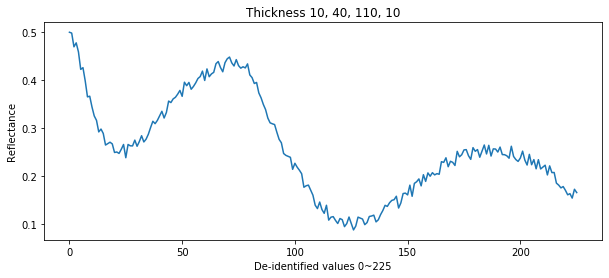

In [34]:
plot_reflectance(dacon_data.loc[3000], rev=True)

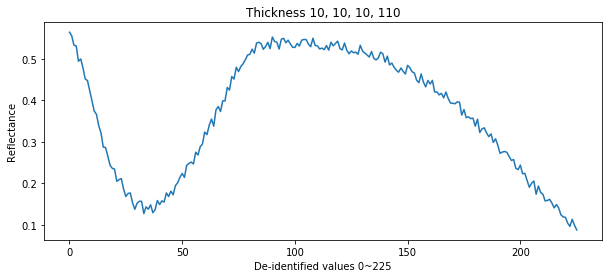

In [35]:
plot_reflectance(dacon_data.loc[10], rev=True)

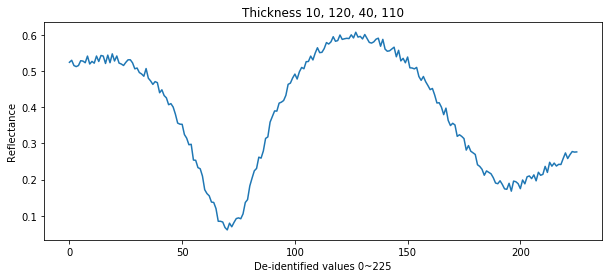

In [36]:
plot_reflectance(dacon_data.loc[10000], rev=True)

## Build a Base Model

As discussed in the original blog post, we attempt to build a baseline model here. The three algorithms used here are Support Vector Regression, Passive Aggressive Regressor, and XGBoost. We could try more such as Deep Learning, but leaving the bigger task to the community!

In [37]:
def create_train_test_split(data_set : pd.DataFrame) -> dict:
    """ Create a Training, Test and Validation Split from the data
        :params data_set; Dataset for splitting
        :returns data_split: training testing and validation as list of DataFrames
        The function will split data by 60 20 20
        Reference - https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
    """
    train, validate, test = np.split(data_set.sample(frac=1),
                                     [int(.6*len(data_set)),
                                      int(.8*len(data_set))])
    
    return {'train':train, 'test':test,'validate':validate}

In [38]:
data_split = create_train_test_split(dacon_data)

In [39]:
X_train = data_split['train']

In [40]:
X_train = data_split['train'][dacon_data.columns[4:]]
y_train = data_split['train'][dacon_data.columns[:4]]

### Support Vector Regression Model

In [41]:
svm_ = LinearSVR()
svm_mo_regressor = MultiOutputRegressor(svm_)

In [42]:
_ = svm_mo_regressor.fit(X_train,
                    y_train)

In [43]:
X_val = data_split['validate'][dacon_data.columns[4:]]
y_val = data_split['validate'][dacon_data.columns[:4]]

In [44]:
val_pred = svm_mo_regressor.predict(X_val)

In [45]:
mean_absolute_error(y_val, val_pred)

73.284922352966

We got an RMSE of 73.22 with this model!

#### Passive Aggresive Regression

In [46]:
par = PassiveAggressiveRegressor()
po_mo_regressor = MultiOutputRegressor(par)

In [47]:
_ = po_mo_regressor.fit(X_train,
                    y_train)

In [48]:
val_pred_pa = po_mo_regressor.predict(X_val)
mean_absolute_error(y_val, val_pred_pa)

78.50190112498728

We got an RMSE of 83.53 with this model!

### XGBoost

In [49]:
xgbr = XGBRegressor(n_estimators=1000,
                    max_depth=7, 
                    eta=0.1,
                    subsample=0.7,
                    colsample_bytree=0.8,
                   n_jobs=4)
mo_xgb = MultiOutputRegressor(xgbr)

In [ ]:
_ = mo_xgb.fit(X_train, y_train)

In [ ]:
xgb_pred = mo_xgb.predict(X_val)

In [ ]:
mean_absolute_error(y_val, xgb_pred)

We got an RMSE of 83.53 with this model!

### Reference
[1] https://archive.ics.uci.edu/ml/datasets/SECOM 